# Data Science Project

![OSEMN](../imgs/osemn.png)

> Image from: [https://www.datascience-pm.com/osemn/](https://www.datascience-pm.com/osemn/)

# BAYESIAN A/B TESTING METHODOLOGY (OSEMN)

## Step 0: Obtain (Data + Business Understanding)
### Background

#### What is the company?  
Tactile Entertainment

#### What does the company do?  
Tactile Entertainment develops mobile games. Its flagship game, **Cookie Cats**, is a popular puzzle game where players connect tiles of the same color to clear levels. The game includes in-app purchases, time-based gates, and engagement features to enhance retention.


#### How does the company make money?  
Revenue comes from **in-app purchases (IAPs)** and advertising. Players may encounter gates that limit progression unless they wait or pay, generating monetization opportunities.

##### Example:
- Original gate: Level 30  
- Players must wait or pay to continue  
- Revenue is generated if the player purchases skips  
- Estimated revenue per retained player:
  - $2 from IAPs (players buy skips or boosters)
  - $1 from ads (ad impressions while waiting or playing)
  - Total: $3 per retained player


#### What challenge is the company facing?  
The first gate has been moved from **level 30 to level 40**. Tactile Entertainment wants to understand:
- How delaying the first gate impacts **player retention**  


The goal is to **analyze A/B test results using a Bayesian framework** and provide clear recommendations for game design.





## Step 1: Scrub (Data Understanding)


### Imports   

> **Remark:** I developed a class from scratch to perform Bayesian A/B testing, which I have also published on PyPI. We are importing it here for use in this project.
 

In [1]:
import os
import sys
import json
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ab_bayes_test import ABBayesTest

# -----------------------------
# Local application imports
# -----------------------------
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)
from  src.helper_functions import (summarize_dataframe, 
                                   boxplot_outliers_groups,
                                   histogram_groups,
                                   categorical_distribution_groups,
                                   plot_histograms_data_1vsdata_2,
                                   plot_histogram_single,
                                   simulate_profit_posterior,
                                   plot_kde_data1vsdata_2_same_plot,
                                   display_recommendation
                                   )

### Load Data

In [2]:
df_raw = pd.read_csv("../data/cookie_cats.csv")
display(df_raw.head(11))
display(df_raw.info())

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


None

### Converting userid to a string 


In [3]:
df_raw['userid'] = df_raw['userid'].astype(str)

### Data Description
- Player-level anonymized data  
- Control group: first gate at level 30  
- Experiment group: first gate at level 40  
- Metrics available in this dataset:  
  - Retention (Day 1, Day 7)  
  - Total game rounds played

### EDA 

#### Data Quality Checks 

##### Restore DataFrame Copy

In [4]:
df_checks = df_raw.copy()

In [5]:
with pd.option_context(
    'display.max_columns', None,
    'display.max_rows', None,
    'display.max_colwidth', None
):
    summarize_dataframe(df_checks)

===== DATA OVERVIEW =====


,Num NAs,Percent NAs,Num unique,Data Type
userid,0,0.0,90189,object
version,0,0.0,2,object
sum_gamerounds,0,0.0,942,int64
retention_1,0,0.0,2,bool
retention_7,0,0.0,2,bool



DataFrame shape: (90189, 5)



,attribute,mean,median,std,min,max,range,skew,kurtosis,IQR,lower_bound,upper_bound,num_outliers,prop_outliers_%,pct_2,pct_5,pct_10,pct_25,pct_50,pct_75,pct_90,pct_95,pct_98
0,sum_gamerounds,51.87,16.0,195.05,0,49854,49854,185.44,47130.37,46.0,-64.0,120.0,10177,11.28,0.0,1.0,1.0,5.0,16.0,51.0,134.0,221.0,364.0


===== CATEGORICAL / BOOLEAN STATS =====

Column: userid


,Value,Count,Percent
userid,,,
9999861,9999861,1,0.0
116,116,1,0.0
337,337,1,0.0
377,377,1,0.0
483,483,1,0.0



Column: version


,Value,Count,Percent
version,,,
gate_40,gate_40,45489,50.44
gate_30,gate_30,44700,49.56



Column: retention_1


,Value,Count,Percent
retention_1,,,
False,False,50036,55.48
True,True,40153,44.52



Column: retention_7


,Value,Count,Percent
retention_7,,,
False,False,73408,81.39
True,True,16781,18.61



DataFrame head (5 rows):


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


As we can observe, there are no missing values in the dataset. The data is well balanced between the control (gate_30) and treatment (gate_40) groups.

Approximately 11% of sum_gamerounds values are outliers, which is reflected by its high skewness (mean > 3 × median) and heavy right tails (high kurtosis). We will address this numeric variable later using a Box-Cox transformation.

#### Box plot and distribution of `sum_gamerounds`

> **Note:**  
    Due to heavy tails (outliers) in the data, we apply a 0–95th percentile filter for better visualization.  
    Outliers are computed on the full dataset *before* filtering, and the mean and median are calculated similarly on the full data.


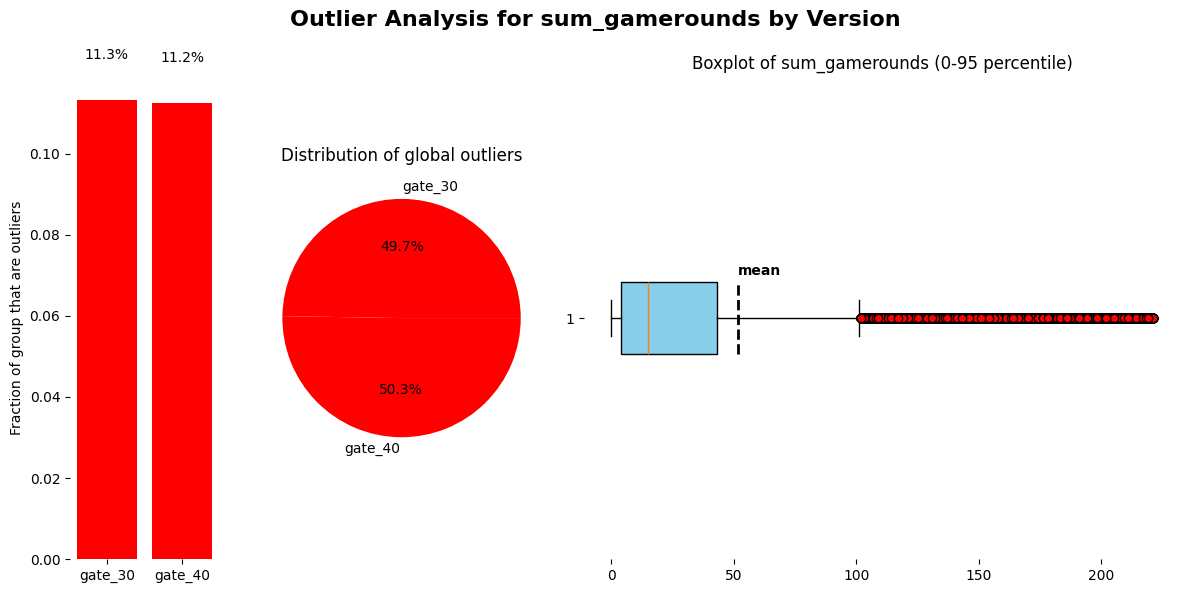

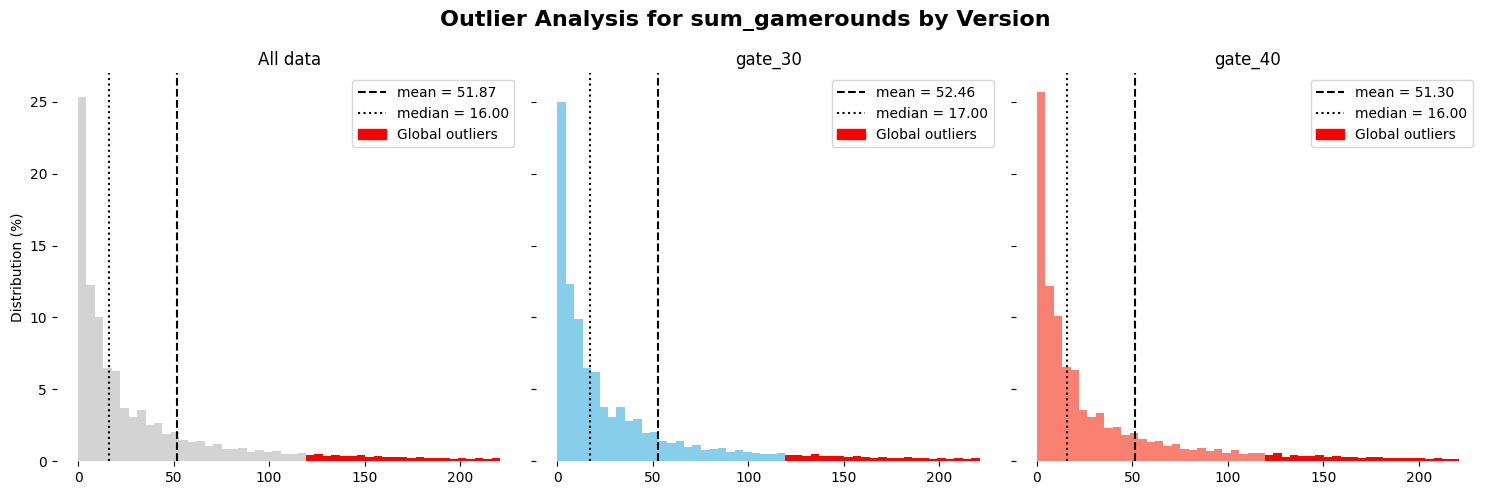

In [6]:
boxplot_outliers_groups(
    df=df_checks,              
    column='sum_gamerounds', 
    label_col='version',     
    outlier_color='red',     
    title='Outlier Analysis for sum_gamerounds by Version',
    percentile_filter=(0, 95),  # optional: filter extreme percentiles
    show_mean=True
)

histogram_groups(
    df=df_checks,              
    column='sum_gamerounds', 
    label_col='version',     
    outlier_color='red',     
    title='Outlier Analysis for sum_gamerounds by Version',
    percentile_filter=(0, 95),  
    show_mean=True,
    show_median = True,
    bins = 50
)


> The distribution and boxplot, together with the distribution of outliers in `sum_gamerounds`,  visually confirm what was already observed from the summary measures (mean, median, skew, kurtosis, percentiles, and the proportion of outliers).
In addition, the first plot shows that the outliers are uniformly distributed across the versions. The second plot suggests that there is no noticeable difference between the distributions of gate_30 and gate_40. The mean and median of gate_30 are slightly higher than those of gate_40, but we would expect that, statistically, there is no significant evidence supporting this difference.

#### BoxCox Transformation on `sum_gamerounds` 

In [7]:
# Copy positive values (Box-Cox requires y > 0)
y = df_raw['sum_gamerounds'].copy()
#Check y > 0:
if (y <=0).any():
    y+=1
# Apply Box-Cox transformation
y_boxcox, lambda_ = stats.boxcox(y)

# Add new column to the DataFrame
df_checks['sum_gamerounds_boxcox'] = y_boxcox

print(f"Lambda used for Box-Cox: {lambda_:.4f}")

#Output: 
#Lambda used for Box-Cox: -0.0302

Lambda used for Box-Cox: -0.0302


As we can see, the optimal lambda value is close to zero, meaning that the Box-Cox transformation behaves similarly to a logarithmic one. Therefore, for simplicity, we apply the log(y + 1) transformation instead of the Box-Cox.

#### $\log$ Transformation on `sum_gamerounds` 

In [8]:
df_checks['sum_gamerounds_log'] =  np.log1p(df_checks['sum_gamerounds'])

#### Distribution of `sum_gamerounds_log` and `sum_gamerounds_boxcox`
> **Note:**  
No filtering is applied here, as there are practically no outliers.  
Boxplots are not necessary.  
These distributions already reflect the quality checks that effectively removed outliers and corrected skewness.

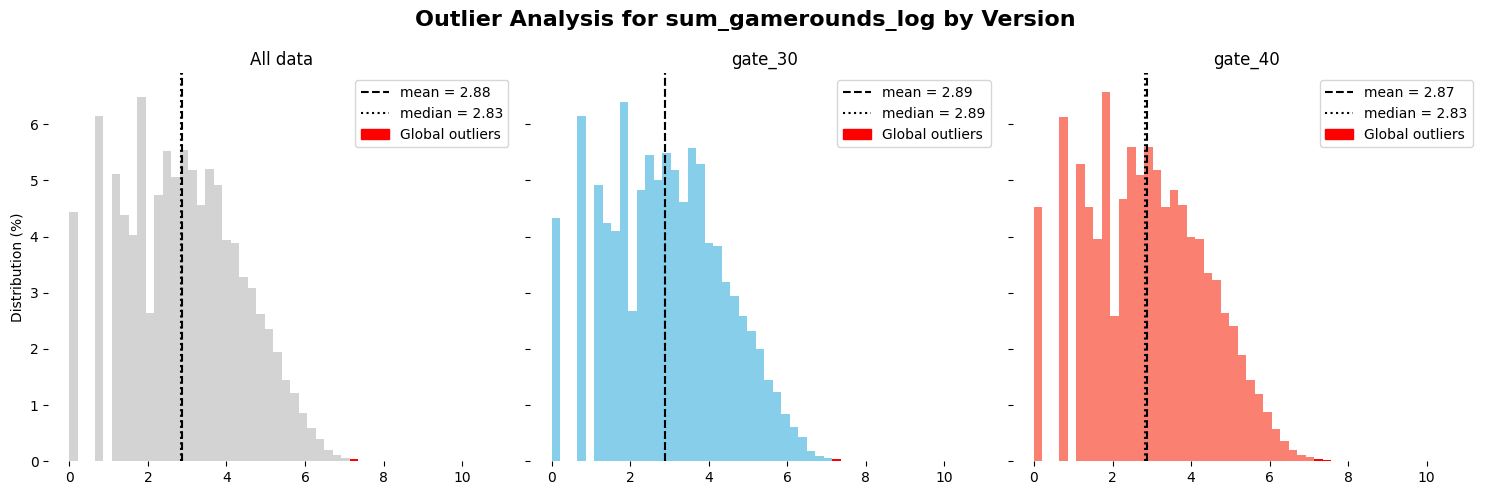

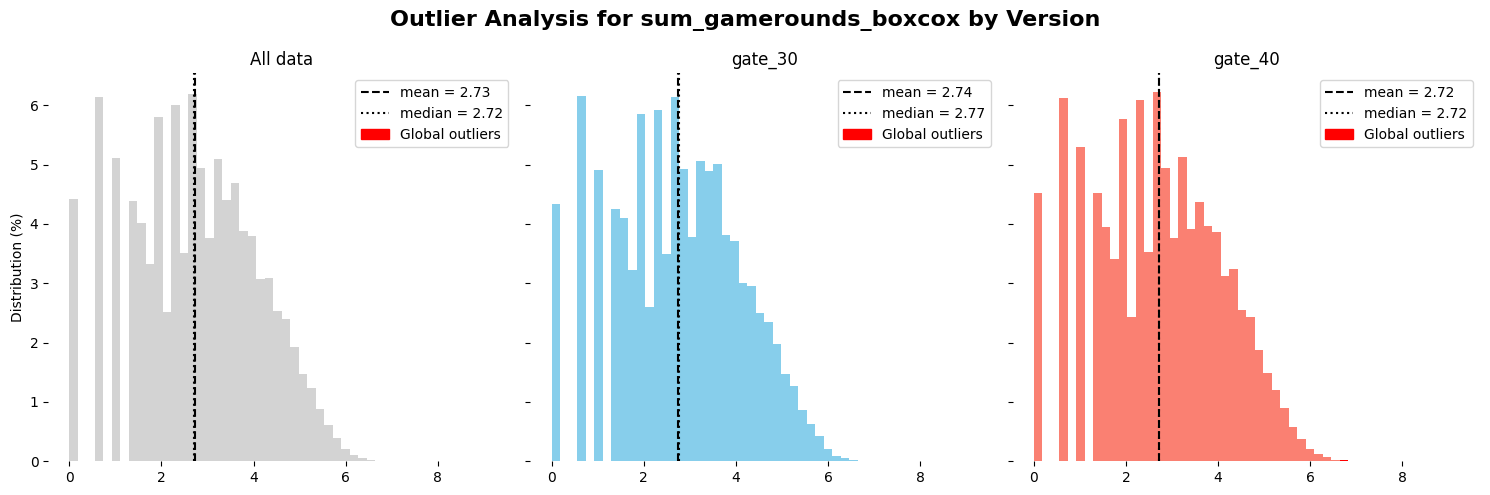

In [9]:

histogram_groups(
    df=df_checks,              
    column='sum_gamerounds_log', 
    label_col='version',     
    outlier_color='red',     
    title='Outlier Analysis for sum_gamerounds_log by Version',
    percentile_filter=(0, 100),  # optional: filter extreme percentiles
    show_mean=True,
    show_median = True,
    bins = 50
)

histogram_groups(
    df=df_checks,              
    column='sum_gamerounds_boxcox', 
    label_col='version',     
    outlier_color='red',     
    title='Outlier Analysis for sum_gamerounds_boxcox by Version',
    percentile_filter=(0, 100),  # optional: filter extreme percentiles
    show_mean=True,
    show_median = True,
    bins = 50
)


#### Data Quality Checks

In [10]:
with pd.option_context(
    'display.max_columns', None,
    'display.max_rows', None,
    'display.max_colwidth', None
):
    summarize_dataframe(df_checks[['sum_gamerounds_log','sum_gamerounds_boxcox']])


===== DATA OVERVIEW =====


,Num NAs,Percent NAs,Num unique,Data Type
sum_gamerounds_log,0,0.0,942,float64
sum_gamerounds_boxcox,0,0.0,942,float64



DataFrame shape: (90189, 2)



,attribute,mean,median,std,min,max,range,skew,kurtosis,IQR,lower_bound,upper_bound,num_outliers,prop_outliers_%,pct_2,pct_5,pct_10,pct_25,pct_50,pct_75,pct_90,pct_95,pct_98
0,sum_gamerounds_log,2.88,2.83,1.50,0.0,10.82,10.82,0.10,-0.58,2.16,-1.45,7.19,41,0.05,0.0,0.69,0.69,1.79,2.83,3.95,4.91,5.40,5.9
1,sum_gamerounds_boxcox,2.73,2.72,1.38,0.0,9.23,9.23,0.01,-0.62,1.98,-1.23,6.69,12,0.01,0.0,0.69,0.69,1.74,2.72,3.72,4.56,4.98,5.4



DataFrame head (5 rows):


,sum_gamerounds_log,sum_gamerounds_boxcox
0,1.386294,1.357632
1,3.663562,3.467873
2,5.111988,4.736380
3,0.693147,0.685932
4,5.192957,4.805665


From the histogram (showing all data, without any filtering), which also displays the median and mean, the log+1 transformation effectively removed almost all outliers. The proportion of outliers dropped from approximately 11% to 0.05%, since the mean and median became almost equal. We also plotted the distribution after the Box-Cox transformation, and, as expected, there was no noticeable difference compared to the log+1 transformation. 


We can also observe that slightly more than 4% and less than 4.5% of the 'sum_gamerounds_log' are null. Note that 0 is preserved by the transformation (log(0 + 1) = 0). We will remove the null values.

#### Remove null values 

In [11]:
df_checks = df_checks.query("sum_gamerounds > 0")

#### Check dimension 

In [12]:
initial_shape =  df_raw.shape
new_shape =  df_checks.shape
drop_pct = 100 * (initial_shape[0] - new_shape[0]) / initial_shape[0] 
print(f"Dimension of the entire dataset: {initial_shape}\n"
      f"Dimension after removing zero sum_gamerounds: {new_shape} \n "
      f"(drop of {drop_pct:.2f}% of rows), as expected!")

Dimension of the entire dataset: (90189, 5)
Dimension after removing zero sum_gamerounds: (86195, 7) 
 (drop of 4.43% of rows), as expected!


#### Distributions of retention rates for each group

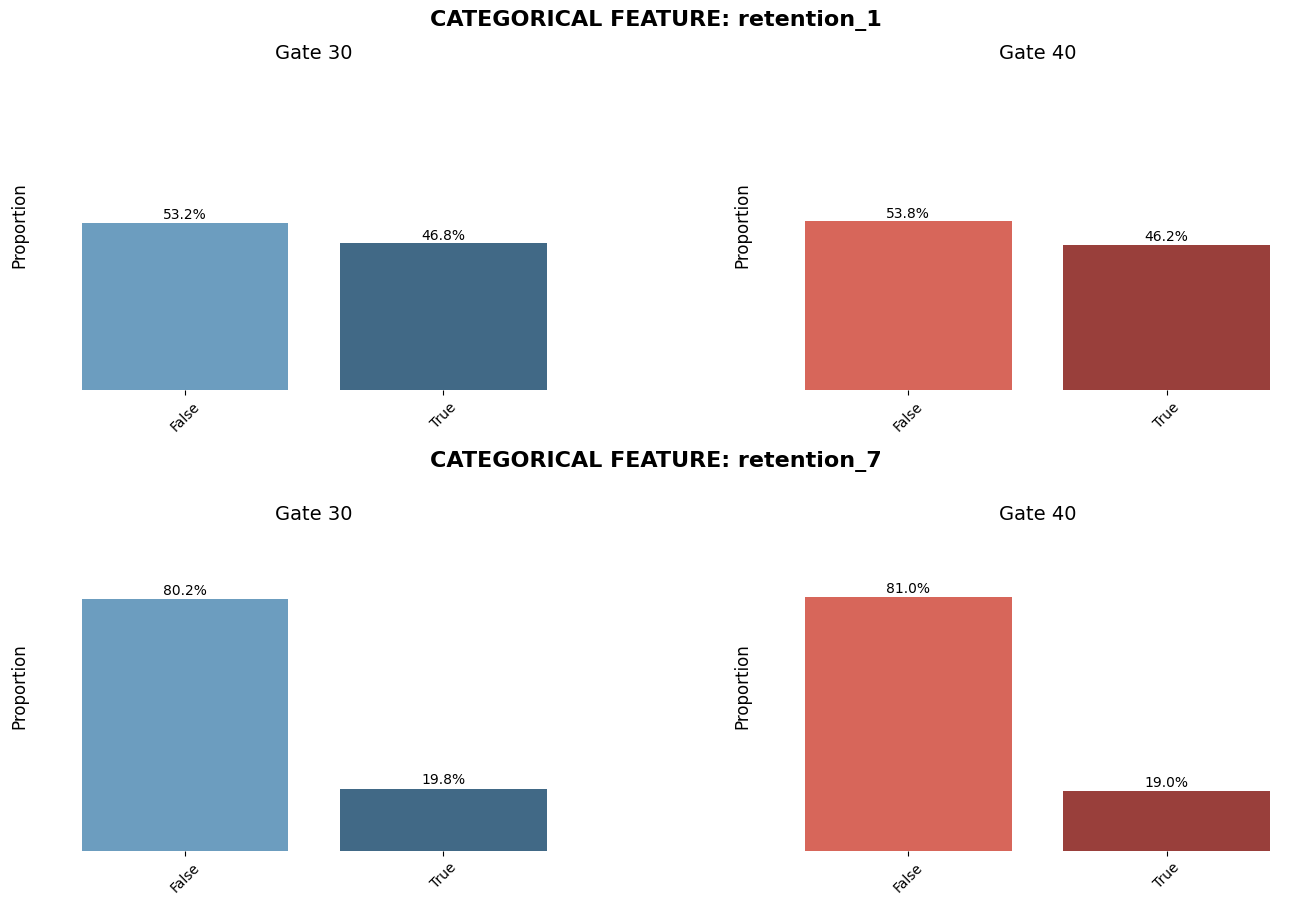

In [13]:
# ----------------------------------------------------------------------------------
# Plotting categorical distributions of retention rates for each group (Gate 30 / Gate 40)
# ----------------------------------------------------------------------------------
# This function call generates side-by-side bar plots for the columns "retention_1" and "retention_7"
# grouped by "version" (i.e., Gate 30 and Gate 40). 
# - Each group (Gate 30 and Gate 40) is treated independently.
# - The height of the bars represents the proportion of players in that group that fall into 
#   each category of "retention_1" or "retention_7".
# - This is useful to compare the distribution of retention **within each gate**,
#   not the overall retention across all players.

categorical_distribution_groups(
    df = df_checks,
    categorical_cols = ["retention_1","retention_7"],
    target_col= "version",
    top_k  = None,
    group_titles = ("Gate 30", "Gate 40"),
    global_normalize = False,
    normalize_within_group = True
)

The 1-day retention is very similar between the two versions (~0.6 percentage points difference).
The 7-day retention shows a slightly larger gap (~0.8 percentage points), but it is still quite small.
Visually and descriptively, there is no strong difference between Gate 30 and Gate 40 in retaining players, so we expect no strong evidence of a significant improvement in Gate 40.
Nevertheless, we will run a Bayesian A/B test to confirm this. 


#### Distributions of retention rates above/below mean for each group 
Remember that the mean of sum_gamerounds is approximately 50, and note that after the log transformation, the mean and median are practically equal.
Therefore, we will analyze the behavior of retention_1 and retention_7 between Gate 30 and Gate 40 for players with sum_gamerounds_log **less than or equal to the mean and greater than the mean**. 

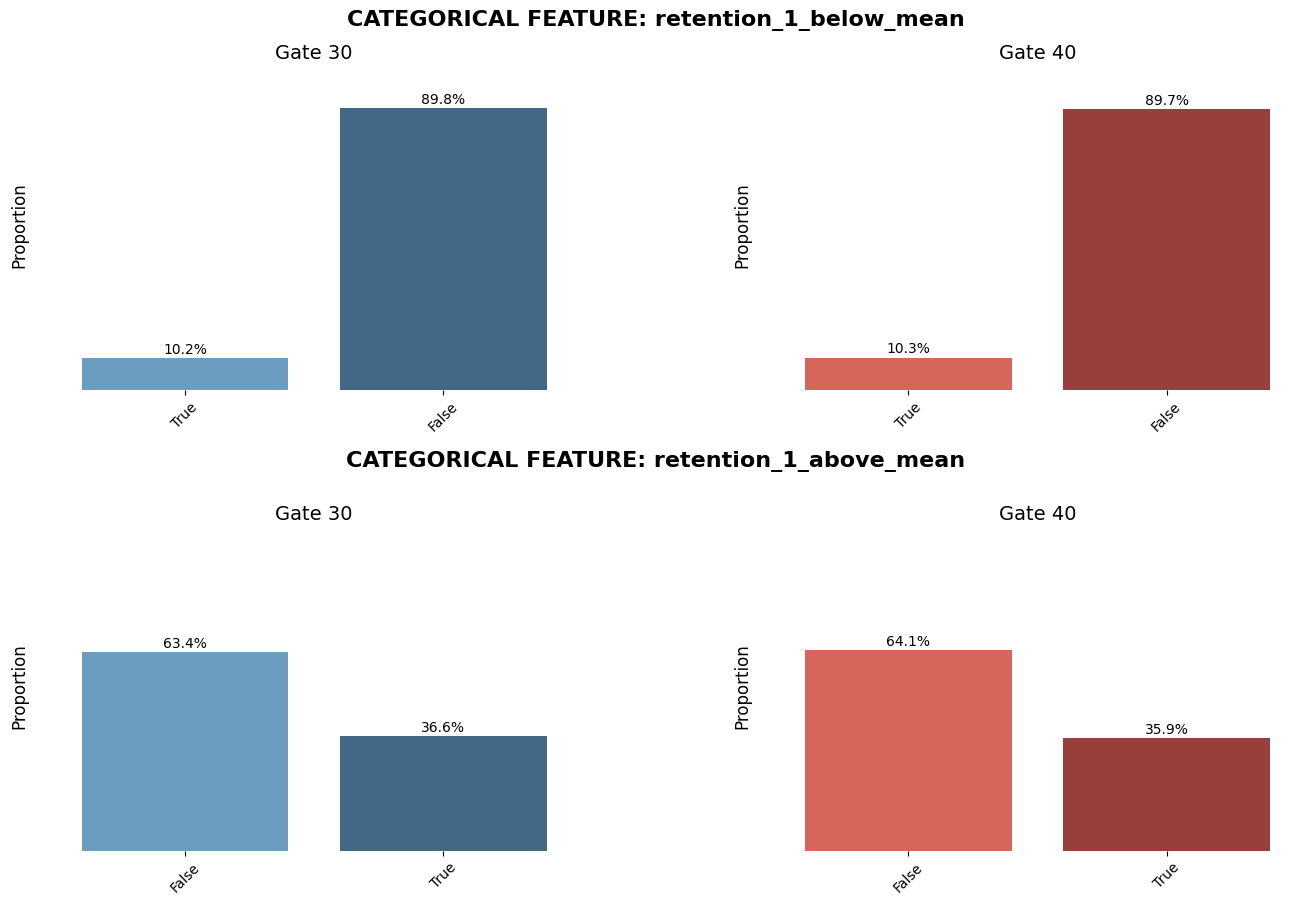

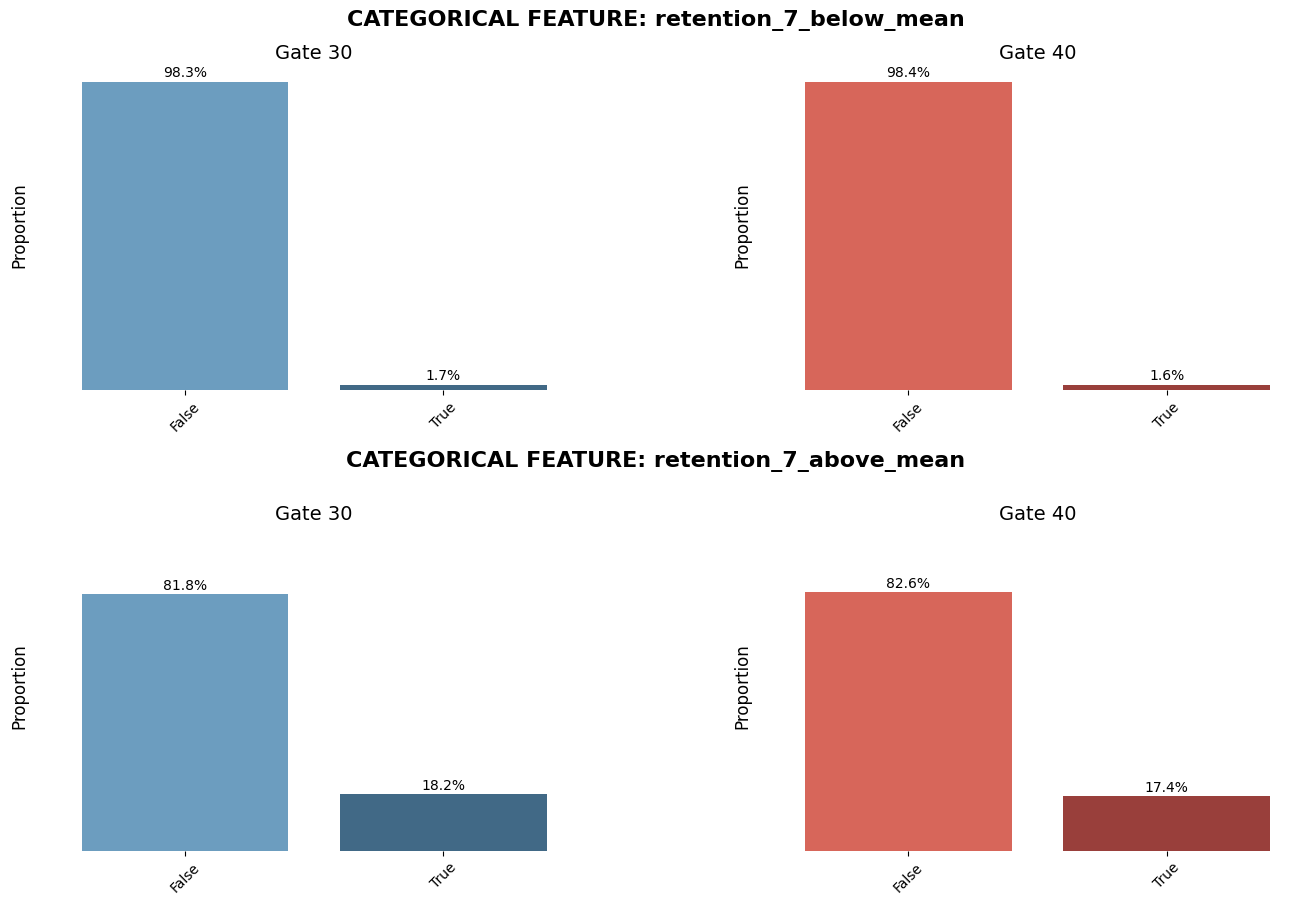

In [14]:
mean_log = df_checks['sum_gamerounds_log'].mean()

# Create boolean columns
df_checks['retention_1_above_mean'] = df_checks['retention_1'] & (df_checks['sum_gamerounds_log'] > mean_log)
df_checks['retention_1_below_mean'] = df_checks['retention_1'] & (df_checks['sum_gamerounds_log'] <= mean_log)

df_checks['retention_7_above_mean'] = df_checks['retention_7'] & (df_checks['sum_gamerounds_log'] > mean_log)
df_checks['retention_7_below_mean'] = df_checks['retention_7'] & (df_checks['sum_gamerounds_log'] <= mean_log)


categorical_distribution_groups(
    df = df_checks,
    categorical_cols = ["retention_1_below_mean","retention_1_above_mean" ],
    target_col= "version",
    top_k  = None,
    group_titles = ("Gate 30", "Gate 40"),
    global_normalize = False,
    normalize_within_group = True,
    top  = 0.9,
    hspace = 0.8,
    wspace = 0.4,

    )


categorical_distribution_groups(
    df = df_checks,
    categorical_cols = ["retention_7_below_mean","retention_7_above_mean" ],
    target_col= "version",
    top_k  = None,
    group_titles = ("Gate 30", "Gate 40"),
    global_normalize = False,
    normalize_within_group = True,
    top  = 0.9,
    hspace = 0.8,
    wspace = 0.4,
    )



From the distribution of retention for values below and above the threshold, there appears to be a strong association with `sum_gamerounds_log`. When this variable is above the mean, the proportion of users retained tends to increase.

Specifically, for values above the mean, the proportion of users in retention_1 and retention_7 is significantly higher. For example, the retention rate increases from 1.7% to 18.2%, which is more than 9 times higher. This indicates that higher engagement (more game rounds) strongly correlates with retention.

So, We can see that retention is higher for 1 and 7 days as players starts playing more than the average 50 Game Rounds ($50 \longrightarrow \text{mean}_{\text{sum\_gamerounds\_log}} \approx 3.013$)

#### Retention Rate for Each Group

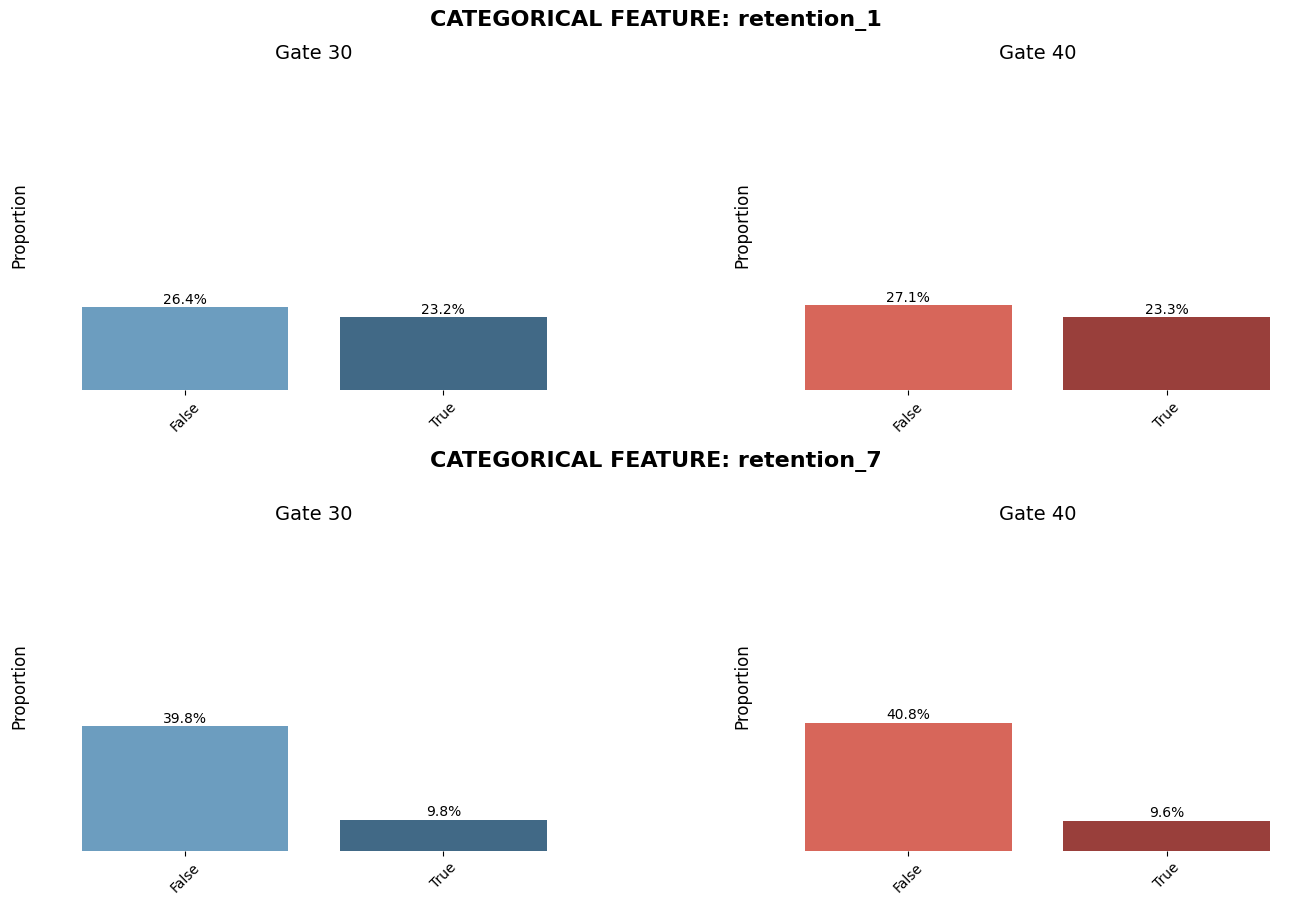

In [15]:
# ----------------------------------------------------------------------------------
# Here we do not have a classical distribution that sums to 100%.
# Instead, the interpretation is the contribution of a single player in each group
# relative to the total number of players.
# This helps to understand the overall impact of each group and retention category
# on the total player base, rather than the internal distribution within each group.
# ----------------------------------------------------------------------------------

categorical_distribution_groups(
    df=df_checks,
    categorical_cols=["retention_1", "retention_7"],   
    target_col="version",                              
    group_titles=("Gate 30", "Gate 40"),
    global_normalize=True,
    normalize_within_group=False
)

#### Bad Users in Both Groups

In [16]:
## Bad Users in Both Groups
# ----
# Detect users who appear as bad in both Gate 30 and Gate 40 simultaneously.
# ----
df_checks[['version','userid']].groupby('userid').nunique().query('version > 1').reset_index()

# Output: Empty DataFrame -> No users are in both groups, all good!


,userid,version



## Step 2: Explore (Analysis Plan)
### Objective
Measure impact of moving the first gate on retention, engagement, and monetization using a **Bayesian A/B testing approach**.

- Gate 30 = Control Group
- Gate 40 = Treatment Group


- Parameter of Interest: Retention probability in each group: 
$
\theta_{control}, \theta_{treatment}
$
- Prior: $\theta_i \sim \text{Beta}(1,1)$ (non-informative prior)
- Likelihood: 
$$
Retention_i \sim \text{Binomial}(n_i, \theta_i), \quad i \in \{control, treatment\}
$$
- Posterior: Compute 
$$
\text{Prob}(\theta_{control} | data) \text{ and } \text{Prob}(\theta_{treatment} | data)
$$
- Decision Rule: 
$$
\text{Prob}(\theta_{treatment} > \theta_{control})
$$
- Credible Level: e.g., 0.95 for the posterior probability




## Step 3: Model (Procedure / IPR)

![IPR Solution](../imgs/IPR_method_4.png) 
> Reference: [https://medium.com/@thiago.guimaraes.sto/thinking-about-data-science-structurally-the-quadruple-d-h-m-s-781eee1af2ff](https://medium.com/@thiago.guimaraes.sto/thinking-about-data-science-structurally-the-quadruple-d-h-m-s-781eee1af2ff)

| Step       | Description |
|-----------|-------------|
| **Input** | - Business problem and hypotheses<br>- A/B test dataset (control vs experiment)<br>- Metrics of interest: retention<br>- Prior assumptions for Bayesian models (weakly informative or historical priors) |
| **Procedure** | - Clean and prepare dataset<br>- Validate random assignment of players<br>- Fit Bayesian models for retention, engagement<br>  - Retention: Beta-Binomial model<br>  - Engagement/revenue: Normal or log-Normal model<br>- Compute posterior distributions and credible intervals<br>- Calculate probability of improvement for each metric<br>- Visualize posteriors, credible intervals, and probability of lift |
| **Result** | - Posterior distributions for retention, engagement, and revenue<br>- Probability that moving the gate increases retention or revenue<br>- Credible intervals for metric differences<br>- Recommendations for gate placement based on Bayesian evidence |


### Retention Metrics

In [17]:
## Instantiate A/B tests
# -----------------------
ab_test_retention_1 = ABBayesTest(
    df=df_checks,
    group_col='version',
    value_col='retention_1',    # Retention at day 1
    metric_type='proportion',
    inference_type='conjugate',
    prior_params=None,
    sampling_size=10000,
    control_group='gate_30',
    treatment_group='gate_40'
)

ab_test_retention_7 = ABBayesTest(
    df=df_checks,
    group_col='version',
    value_col='retention_7',    # Retention at day 7
    metric_type='proportion',
    inference_type='conjugate',
    prior_params=None,
    sampling_size=10000,
    control_group='gate_30',
    treatment_group='gate_40'
)

## Fit the tests
# -----------------------
ab_test_retention_1.fit()
ab_test_retention_7.fit()

## Posterior summary
# -----------------------
posterior_summary_retention_1 = ab_test_retention_1.results(ci=0.95)
posterior_summary_retention_7 = ab_test_retention_7.results(ci=0.95)

## Posterior distributions
# -----------------------
posterior_samples_retention_1 = ab_test_retention_1.get_distributions()
posterior_samples_retention_7 = ab_test_retention_7.get_distributions()

## Lift summary
# -----------------------
lift_summary_retention_1 = ab_test_retention_1.lift_summary()
lift_summary_retention_7 = ab_test_retention_7.lift_summary()

## Compute lift samples
# -----------------------
lift_samples_retention_1 = posterior_samples_retention_1['gate_40'] / posterior_samples_retention_1['gate_30'] - 1
lift_samples_retention_7 = posterior_samples_retention_7['gate_40'] / posterior_samples_retention_7['gate_30'] - 1


### Total Rounds Played
> We use the `sum_gamerounds` variable, log+1 transformed, which effectively removes skewness and outliers, as highlighted in the EDA section. 

In [18]:
## Instantiate A/B test for Total Rounds Played
# --------------------------------------------
ab_test_total_rounds = ABBayesTest(
    df=df_checks,
    group_col='version',
    value_col='sum_gamerounds_log',  
    metric_type='mean',
    inference_type='conjugate',
    prior_params=None,
    sampling_size=10000,
    control_group='gate_30',
    treatment_group='gate_40'
)

## Fit the test
# --------------------------------------------
ab_test_total_rounds.fit()

## Posterior summary
# --------------------------------------------
posterior_summary_total_rounds = ab_test_total_rounds.results(ci=0.95)

## Posterior distributions
# --------------------------------------------
posterior_samples_total_rounds = ab_test_total_rounds.get_distributions()

## Lift summary
# --------------------------------------------
lift_summary_total_rounds = ab_test_total_rounds.lift_summary()

## Compute lift samples
# --------------------------------------------
lift_samples_total_rounds = posterior_samples_total_rounds['gate_40'] / posterior_samples_total_rounds['gate_30'] - 1

## Step 4: Interpret (Evaluation & Reporting)

- **Summarize results:**
  - Posterior estimates for retention, Total Rounds 
  - Probability of improvement (lift) for each metric
  - 95% credible intervals for differences between control and treatment groups

- **Recommendations:**
  - Move the gate to level 40 if the Bayesian probability of lift exceeds the threshold of 95%

- **Business Performance:**
- Use the posterior lift distribution (with credible intervals) to estimate the potential revenue impact for the company, based on the monetization rules described in the Business Understanding section (e.g., revenue per retained player from IAPs and ads).

- **Deliverable:**
  - PDF containing presentations of the test: one from **PowerPoint** and another from **Beamer (LaTeX)**. See the report folder.
  - HTML report of the entire **Jupyter notebook**. Execute the shell script in the export_to_hmtl folder to  generate it. 

### Retention Day 1 Results
- Posterior summary
- Posterior distributions
- Lift summary
- Lift distributions
- Recommendations


#### Posterior summary

In [19]:
pd.DataFrame(posterior_summary_retention_1)

,gate_30,gate_40
mean,0.467534,0.462182
std,0.002428,0.002431
ci_lower,0.462861,0.457494
ci_upper,0.472329,0.466946


#### Posterior distributions

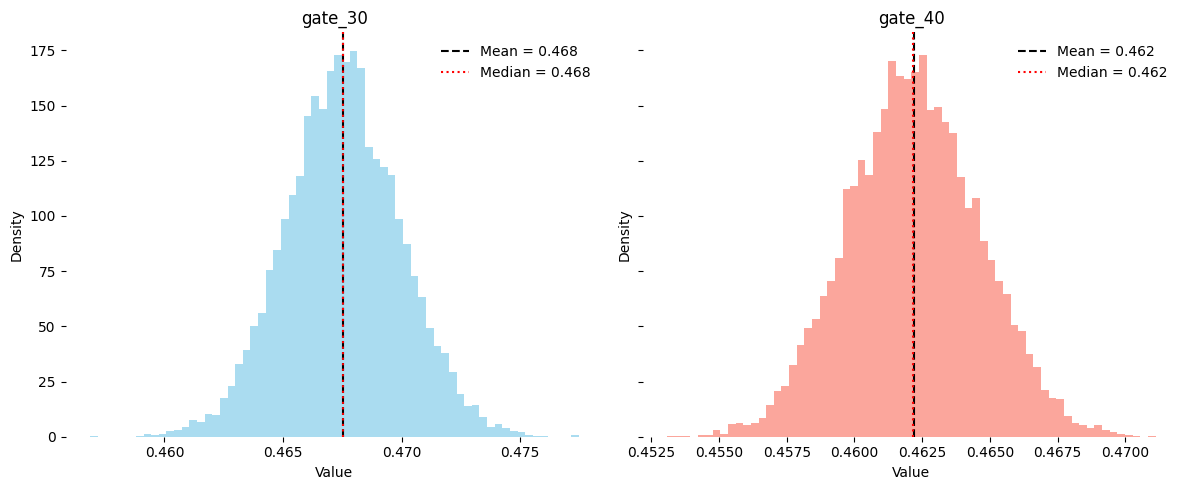

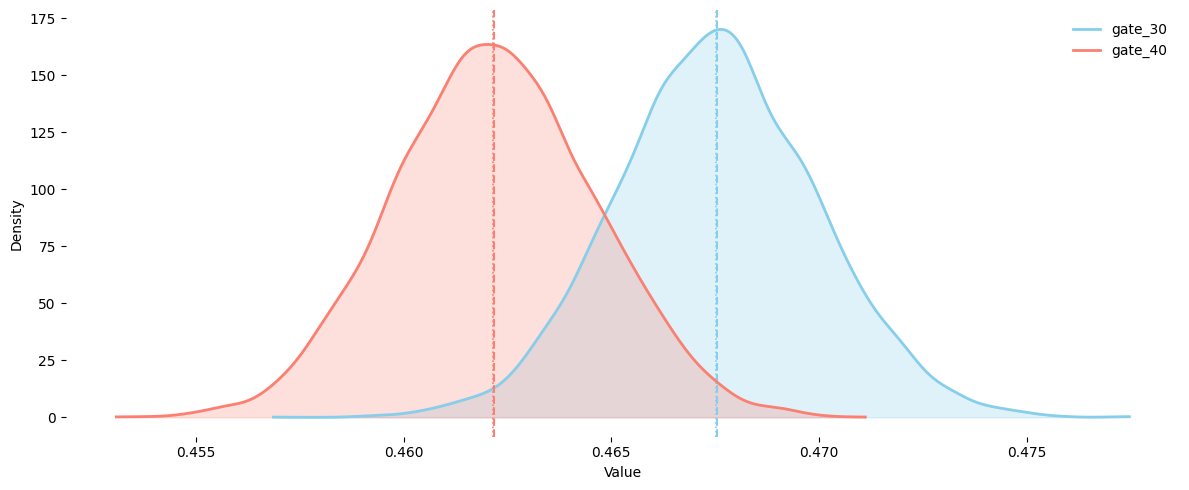

In [20]:
plot_histograms_data_1vsdata_2(posterior_samples_retention_1)
plot_kde_data1vsdata_2_same_plot(posterior_samples_retention_1)

#### Lift summary

In [21]:
print(json.dumps(lift_summary_retention_1, indent=4))

{
    "mean_lift": -0.011419641273036957,
    "std_lift": 0.0073026268108283155,
    "prob_treatment_superior": 0.0594
}


#### Lift distributions

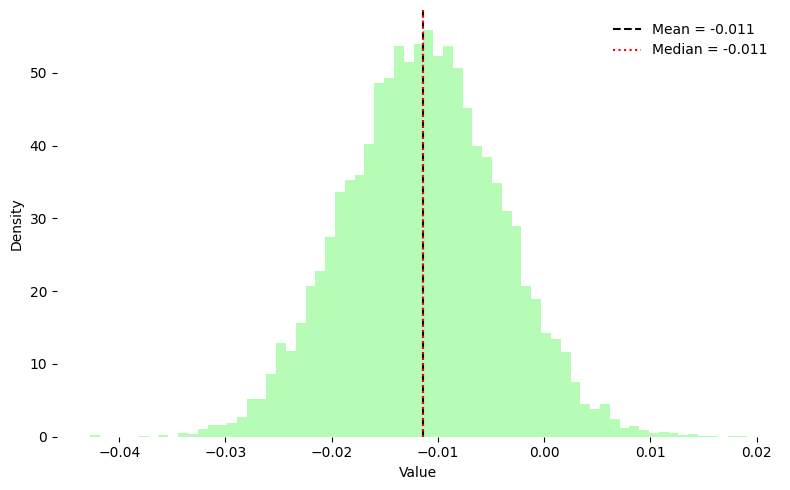

In [22]:
plot_histogram_single(lift_samples_retention_1)

#### Recommendations for Retention Day 1

Based on the Lift summary, we observe that
$$ \text{Prob}(\text{Retention}_1\ \text{in Gate 40} > \text{Retention}_1\ \text{in Gate 30}) = 0.0596 \ (\approx 6\%) $$

This probability is far below the 95% threshold, providing no statistical support that Gate 40 outperforms Gate 30 in 1-day retention.

In [23]:
display_recommendation(
    "<b>Recommendation:</b> Keep Gate 30 as the active version, as the data does not justify switching to Gate 40."
)

### Retention Day 7 Results
- Posterior summary
- Posterior distributions
- Lift summary
- Lift distributions
- Recommendations

#### Posterior summary

In [24]:
pd.DataFrame(posterior_summary_retention_7)

,gate_30,gate_40
mean,0.198431,0.190330
std,0.001937,0.001887
ci_lower,0.194692,0.186652
ci_upper,0.202234,0.194070


#### Posterior distributions

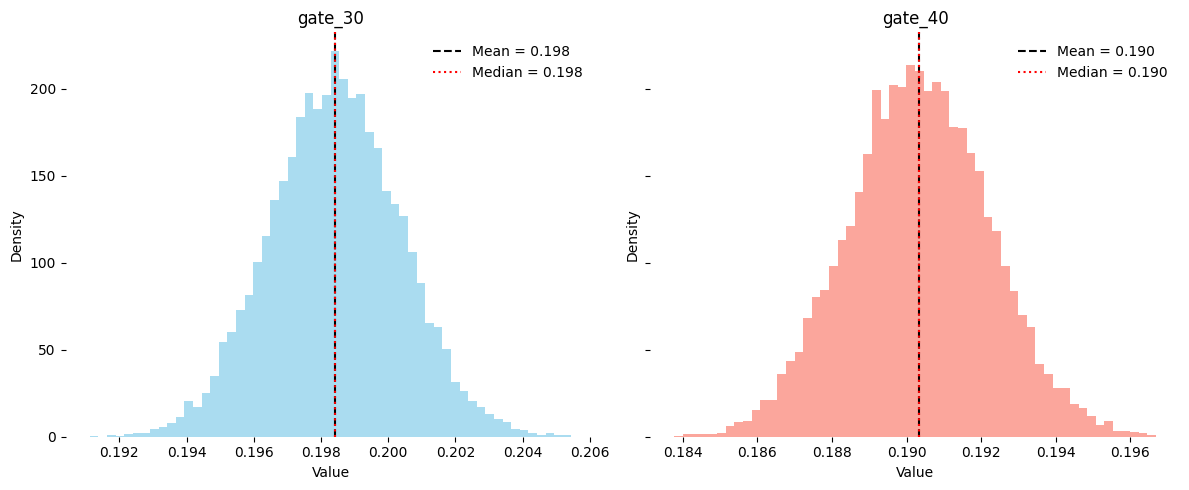

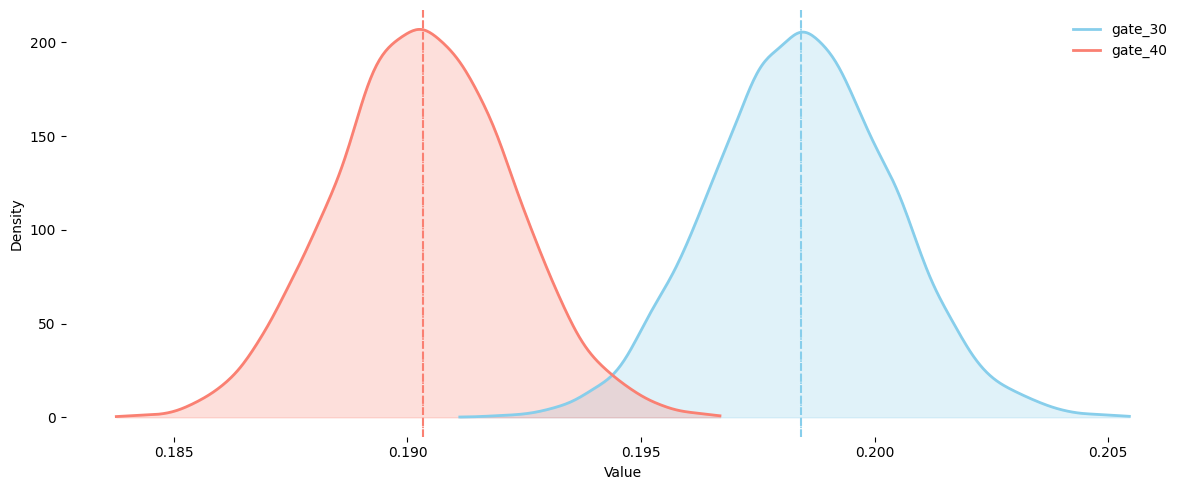

In [25]:
plot_histograms_data_1vsdata_2(posterior_samples_retention_7)
plot_kde_data1vsdata_2_same_plot(posterior_samples_retention_7)

#### Lift summary

In [26]:
print(json.dumps(lift_summary_retention_7, indent=4))

{
    "mean_lift": -0.04073233616923789,
    "std_lift": 0.013411586498434882,
    "prob_treatment_superior": 0.0012
}


#### Lift distributions

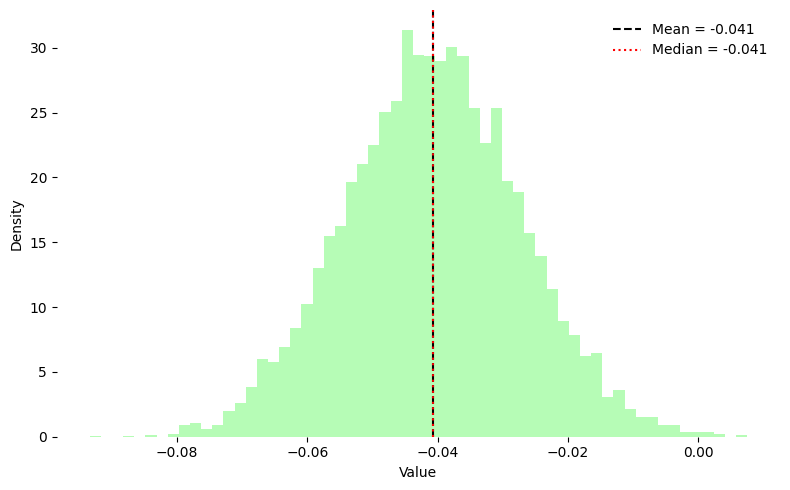

In [27]:
plot_histogram_single(lift_samples_retention_7)

#### Recommendations for Retention Day 7

Based on the Lift summary, we observe that
$$ \text{Prob}(\text{Retention}_7\ \text{in Gate 40} > \text{Retention}_7\ \text{in Gate 30}) = 0.0013 \ (\approx 1\%) $$

This probability is far below the 95% threshold, providing no statistical support that Gate 40 outperforms Gate 30 in 7-day retention.


In [28]:
display_recommendation(
    "<b>Recommendation:</b> Keep Gate 30 as the active version, as the data does not justify switching to Gate 40."
)

### Total Rounds Results
- Posterior summary
- Posterior distributions
- Lift summary
- Lift distributions
- Recommendations

#### Posterior summary


In [29]:
pd.DataFrame(posterior_summary_total_rounds)

,gate_30,gate_40
mean,3.019602,3.006477
std,0.006743,0.006656
ci_lower,3.006502,2.993696
ci_upper,3.032782,3.019577


#### Posterior distributions


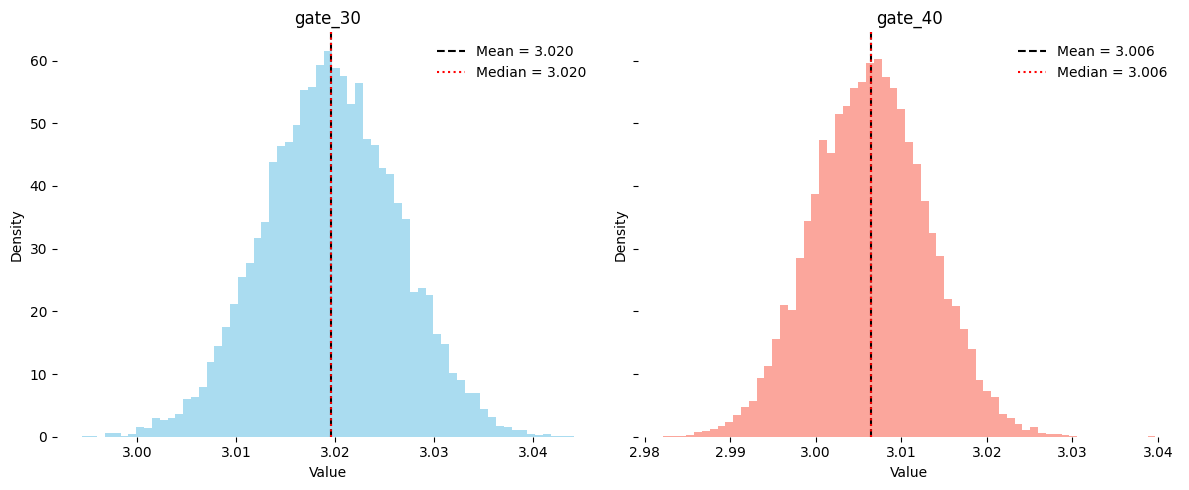

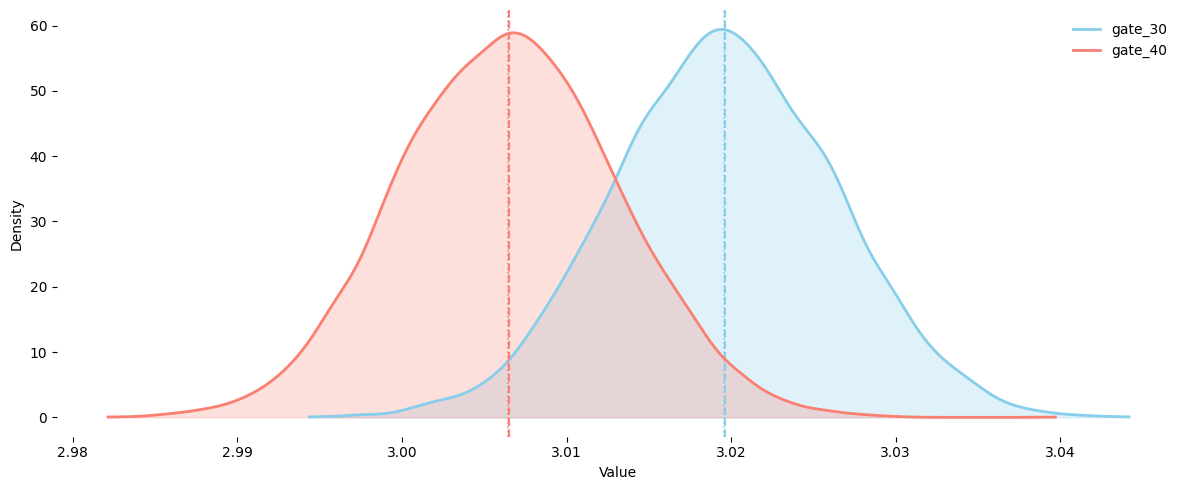

In [30]:
plot_histograms_data_1vsdata_2(posterior_samples_total_rounds)
plot_kde_data1vsdata_2_same_plot(posterior_samples_total_rounds)

#### Lift summary


In [31]:
print(json.dumps(lift_summary_total_rounds, indent=4))

{
    "mean_lift": -0.004341829351071163,
    "std_lift": 0.0031159903354679454,
    "prob_treatment_superior": 0.0819
}


#### Lift distributions

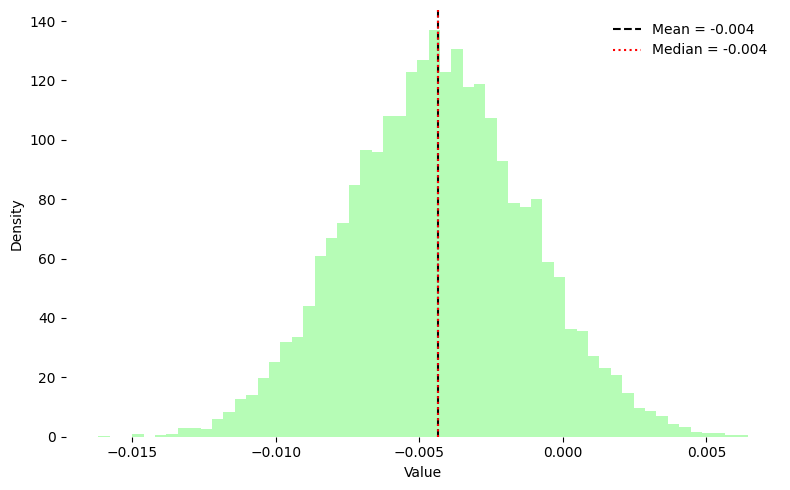

In [32]:
plot_histogram_single(lift_samples_total_rounds)

#### Recommendations
Based on the Lift summary, we observe that
$$ \text{Prob}(\text{Total Rounds }  \text{in Gate 40} > \text{Total Rounds }  \text{in Gate 30}) =0.086\ (\approx 9\%) $$

This probability is far below the 95% threshold, providing no statistical support that Gate 40 outperforms Gate 30 in 7-day retention.

In [33]:
display_recommendation(
    "<b>Recommendation:</b> Keep Gate 30 as the active version, as the data does not justify switching to Gate 40."
)

### Business Performance

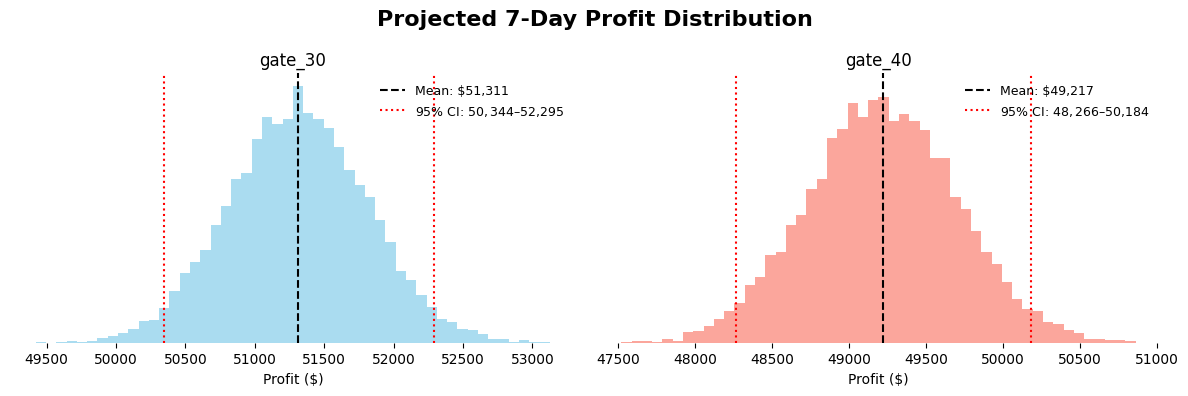

,gate_30,gate_40
mean,51311.342736,49216.574471
std,500.810310,487.839462
ci_lower,50344.359301,48265.528959
ci_upper,52294.631401,50183.604676


In [34]:
# -----------------------------
# Business Rule: Estimated LTV
# -----------------------------
# According to our business understanding, each retained player generates:
# - $2 from in-app purchases (skips, boosters, etc.)
# - $1 from advertising (ad impressions during waiting or gameplay)
# Therefore, total estimated revenue per retained player:
# ltv_per_player = 3 
     
ltv_per_player = 3  
initial_players = len(df_checks)

profit_summary_7d = simulate_profit_posterior(
    posterior_samples_retention_7,
    posterior_summary_retention_7,
    initial_players,
    ltv_per_player=ltv_per_player,
    title="Projected 7-Day Profit Distribution"
) 

display(profit_summary_7d)

### Conclusion

Based on the Bayesian A/B test, we found **no strong evidence to switch versions**. Although the gate 40 version shows slightly higher proportions, the posterior distributions indicate that this difference is not statistically meaningful. Therefore, the recommendation is to **keep gate 30**.

Additionally, using the business rules, we project the **7-day profit** with 95% credible intervals as follows:

- **Gate 30:** USD 50,371 – USD 52,310  
- **Gate 40:** USD 48,271 – USD 50,173

This analysis confirms that gate 30 is expected to generate higher revenue, supporting the recommendation.



### Deliverable

#### PDF


In [ ]:
# ------------------------------------------------------
# A/B Bayesian Test Report Generation
# ------------------------------------------------------
# This script generates both PowerPoint and Beamer (LaTeX) reports
# for the A/B test analysis.
#
# Instructions:
# 1. Navigate to the 'report' folder.
# 2. Execute this script to generate the reports.
# 3. For the Beamer (LaTeX) version, update the author name where needed.
#
# The full pipeline is included below:
# - Data processing and Bayesian modeling
# - Posterior, lift, and summary visualizations
# - PowerPoint slide creation
# - Beamer PDF report generation from existing images

# # =============================
# # Standard library imports
# # =============================
# import os
# import sys
# import warnings
# warnings.filterwarnings("ignore")

# # =============================
# # Third-party imports
# # =============================
# import pandas as pd
# import numpy as np
# import matplotlib
# matplotlib.use('Agg')  # headless backend
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats
# import subprocess
# from pdf2image import convert_from_path
# from pptx import Presentation
# from pptx.util import Inches, Pt
# from pptx.enum.text import PP_ALIGN
# from pptx.dml.color import RGBColor
# from ab_bayes_test import ABBayesTest  

# # =============================
# # Local application imports
# # =============================
# current_dir = os.path.dirname(os.path.abspath(__file__))
# project_root = os.path.abspath(os.path.join(current_dir, '..'))
# sys.path.append(project_root)

# from src.helper_functions import (
#     plot_histograms_data_1vsdata_2,
#     plot_histogram_single,
#     plot_kde_data1vsdata_2_same_plot,
#     simulate_profit_posterior
# )
# # -----------------------------
# # PowerPoint Slide Utilities
# # -----------------------------
# def create_graph_slide(prs, title, subtitle, image_path):
#     slide = prs.slides.add_slide(prs.slide_layouts[6])
    
#     # Title
#     textbox = slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(1))
#     tf = textbox.text_frame
#     tf.clear()
    
#     p_title = tf.paragraphs[0]
#     run = p_title.add_run()
#     run.text = title
#     run.font.bold = True
#     run.font.size = Pt(32)
#     run.font.color.rgb = RGBColor(0, 0, 0)
#     p_title.alignment = PP_ALIGN.CENTER

#     # Subtitle
#     if subtitle:
#         p_sub = tf.add_paragraph()
#         run_sub = p_sub.add_run()
#         run_sub.text = subtitle
#         run_sub.font.size = Pt(20)
#         run_sub.font.color.rgb = RGBColor(50, 50, 50)
#         p_sub.alignment = PP_ALIGN.CENTER

#     # Image
#     if image_path:
#         slide.shapes.add_picture(image_path, Inches(0.5), Inches(1.8), width=Inches(9))
    
#     return slide

# def build_presentation(slide_creators, output_file="presentation.pptx"):
#     output_dir = os.path.dirname(output_file)
#     os.makedirs(output_dir, exist_ok=True)
#     prs = Presentation()
#     for func, args in slide_creators:
#         func(prs, **args)
#     prs.save(output_file)
#     print(f"Presentation saved at: {output_file}")

# # -----------------------------
# # LaTeX Slide Utilities
# # -----------------------------
# def create_recommendation_slide_image(value_col, control_group, treatment_group, lift_summary, slides_dir="slides"):
#     os.makedirs(slides_dir, exist_ok=True)
    
#     prob = lift_summary['prob_treatment_superior'] * 100
#     val_col_safe = value_col.replace("_", r"\_")
#     treat_group_safe = treatment_group.replace("_", r"\_")
#     control_group_safe = control_group.replace("_", r"\_")
    
#     path_tex = os.path.join(slides_dir, f"{value_col}_slide_4.tex")
#     path_pdf = os.path.join(slides_dir, f"{value_col}_slide_4.pdf")
#     path_png = os.path.join(slides_dir, f"{value_col}_slide_4.png")

#     latex_content = f"""\\documentclass[16pt]{{article}}
# \\usepackage{{amsmath,amssymb,xcolor}}
# \\usepackage[active,tightpage]{{preview}}
# \\PreviewEnvironment{{center}}
# \\setlength\\parindent{{0pt}}
# \\pagestyle{{empty}}
# \\begin{{document}}
# \\begin{{center}}
# \\textbf{{}}\\\\[1em]
# No statistically significant improvement detected. Maintain current version.\\\\[1em]
# Probability that

# $$
# \\text{{Prob}}(\\text{{Treatment}} > \\text{{Control}}) = {prob:.2f}\\%
# $$

# is far below the 95\\% threshold.
# \\end{{center}}
# \\end{{document}}"""
    
#     with open(path_tex, "w") as f:
#         f.write(latex_content)
    
#     subprocess.run(["pdflatex", "-output-directory", slides_dir, path_tex], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
#     pages = convert_from_path(path_pdf, dpi=200)
#     pages[0].save(path_png, "PNG")
    
#     return path_png

# def create_conclusion_slide_image(value_col="final", slides_dir="slides"):
#     os.makedirs(slides_dir, exist_ok=True)
    
#     path_tex = os.path.join(slides_dir, f"{value_col}_slide_1.tex")
#     path_pdf = os.path.join(slides_dir, f"{value_col}_slide_1.pdf")
#     path_png = os.path.join(slides_dir, f"{value_col}_slide_1.png")

#     latex_content = rf"""\documentclass[16pt]{{article}}
# \usepackage{{amsmath,amssymb,xcolor}}
# \usepackage[active,tightpage]{{preview}}
# \PreviewEnvironment{{center}}
# \setlength\parindent{{0pt}}
# \pagestyle{{empty}}
# \begin{{document}}
# \begin{{center}}
# \textbf{{Final Recommendation}} \\[1em]
# After reviewing all metrics, including retention on Day 1 and Day 7,
# engagement through total rounds, and overall business performance, 
# the results show no consistent evidence that the treatment version delivers better outcomes. \\[1em]
# The recommendation is to keep the current control version and continue monitoring performance 
# over the next cycles.
# \end{{center}}
# \end{{document}}"""

#     with open(path_tex, "w") as f:
#         f.write(latex_content)
    
#     subprocess.run(["pdflatex", "-output-directory", slides_dir, path_tex], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
#     pages = convert_from_path(path_pdf, dpi=200)
#     pages[0].save(path_png, "PNG")
    
#     return path_png

# # -----------------------------
# # Data Preparation
# # -----------------------------
# df_raw = pd.read_csv(os.path.join(project_root, "data", "cookie_cats.csv"))
# df_raw['userid'] = df_raw['userid'].astype(str)
# df_checks = df_raw.copy()
# df_checks['sum_gamerounds_log'] = np.log1p(df_checks['sum_gamerounds'])
# df_checks = df_checks.query("sum_gamerounds > 0")

# # -----------------------------
# # Slide Generation
# # -----------------------------
# def generate_all_slide_images(
#     df=df_checks,
#     group_col='version',
#     value_col='retention_1',
#     metric_type='proportion',
#     inference_type='conjugate',
#     prior_params=None,
#     sampling_size=10000,
#     control_group='gate_30',
#     treatment_group='gate_40',
#     alpha: float = 0.05,
#     slides_dir="slides"
# ):
#     paths = []

#     # Fit Bayesian model
#     ab_test = ABBayesTest(
#         df=df,
#         group_col=group_col,
#         value_col=value_col,
#         metric_type=metric_type,
#         inference_type=inference_type,
#         prior_params=prior_params,
#         sampling_size=sampling_size,
#         control_group=control_group,
#         treatment_group=treatment_group
#     )
#     ab_test.fit()

#     # Posterior distributions and lift
#     posterior_samples = ab_test.get_distributions()
#     lift_samples = posterior_samples[treatment_group] / posterior_samples[control_group] - 1

#     posterior_summary = ab_test.results(1 - alpha)
#     lift_summary = ab_test.lift_summary()

#     df_post = pd.DataFrame(posterior_summary).T.reset_index().rename(columns={'index': 'metric'})
#     df_lift = pd.DataFrame([lift_summary]).T.reset_index().rename(columns={'index':'metric', 0:'value'})

#     # Posterior histogram
#     path1 = f"{slides_dir}/{value_col}_slide_0.png"
#     plot_histograms_data_1vsdata_2(posterior_samples, path_to_save=path1)
#     paths.append(path1)

#     # Posterior KDE
#     path2 = f"{slides_dir}/{value_col}_slide_1.png"
#     plot_kde_data1vsdata_2_same_plot(posterior_samples, path_to_save=path2)
#     paths.append(path2)

#     # Lift distribution
#     path3 = f"{slides_dir}/{value_col}_slide_2.png"
#     plot_histogram_single(lift_samples, path_to_save=path3)
#     paths.append(path3)

#     # Summary tables
#     path4 = f"{slides_dir}/{value_col}_slide_3.png"
#     fig, axes = plt.subplots(2, 1, figsize=(6, 4))

#     axes[0].axis('off')
#     table_post = axes[0].table(
#         cellText=df_post.round(4).values,
#         colLabels=df_post.columns,
#         cellLoc='center',
#         loc='center'
#     )
#     table_post.auto_set_font_size(False)
#     table_post.set_fontsize(9)
#     table_post.scale(1.2, 1.2)

#     axes[1].axis('off')
#     table_lift = axes[1].table(
#         cellText=df_lift.round(4).values,
#         colLabels=df_lift.columns,
#         cellLoc='center',
#         loc='center'
#     )
#     table_lift.auto_set_font_size(False)
#     table_lift.set_fontsize(9)
#     table_lift.scale(1.2, 1.2)

#     plt.tight_layout()
#     plt.savefig(path4, bbox_inches='tight')
#     plt.close()
#     paths.append(path4)

#     # Recommendation slide
#     path5 = create_recommendation_slide_image(
#         value_col=value_col,
#         control_group=control_group,
#         treatment_group=treatment_group,
#         lift_summary=lift_summary
#     )
#     paths.append(path5)

#     # Optional 7-day profit projection
#     path6 = f"{slides_dir}/final_slide_0.png"
#     if value_col == 'retention_7':
#         simulate_profit_posterior(
#             posterior_samples=posterior_samples,
#             posterior_summary=posterior_summary,
#             initial_players=len(df_checks),
#             ltv_per_player=3,
#             title="Projected 7-Day Profit Distribution",
#             path_to_save=path6
#         )
#         paths.append(path6)

#     return paths

# # -----------------------------
# # Generate Slides & PowerPoint
# # -----------------------------
# slides_to_create = {}
# variables = ["retention_1", "retention_7", "sum_gamerounds_log"]

# for var in variables:
#     if "retention" in var:
#         day = "1" if var == "retention_1" else "7"
#         title_prefix = f"Retention Day {day}"
#         metric_type = "proportion"
#     else:
#         title_prefix = "Total Rounds"
#         metric_type = "mean"

#     slides = generate_all_slide_images(
#         df=df_checks,
#         value_col=var,
#         metric_type=metric_type,
#         slides_dir='slides'
#     )

#     slides_to_create[var] = [
#         (create_graph_slide, {"title": title_prefix, "subtitle":"Posterior Distribution", "image_path": slides[0]}),
#         (create_graph_slide, {"title": title_prefix, "subtitle":"Posterior Distribution", "image_path": slides[1]}),
#         (create_graph_slide, {"title": title_prefix, "subtitle":"Lift Distribution", "image_path": slides[2]}),
#         (create_graph_slide, {"title": title_prefix, "subtitle":"Summary", "image_path": slides[3]}),
#         (create_graph_slide, {"title": title_prefix, "subtitle":"Recommendations", "image_path": slides[4]})
#     ]

# # Conclusion slide
# create_conclusion_slide_image()
# slides_to_create["final"] = [
#     (create_graph_slide, {"title":"Business Performance", "subtitle":"Posterior Distribution", "image_path":"slides/final_slide_0.png"}),
#     (create_graph_slide, {"title":"Conclusion", "subtitle":"", "image_path":"slides/final_slide_1.png"})
# ]

# # Combine all slides
# slides_to_create_final = (
#     slides_to_create["retention_1"] +
#     slides_to_create["retention_7"] +
#     slides_to_create["sum_gamerounds_log"] +
#     slides_to_create["final"]
# )

# # Generate PowerPoint
# build_presentation(slides_to_create_final, output_file="powerpoint/ab_test_full_presentation.pptx")

# # -----------------------------
# # LaTeX Beamer Report
# # -----------------------------
# import re

# def latex_escape(s: str) -> str:
#     replacements = {
#         '\\': r'\textbackslash{}',
#         '{': r'\{',
#         '}': r'\}',
#         '$': r'\$',
#         '&': r'\&',
#         '#': r'\#',
#         '_': r'\_',
#         '%': r'\%',
#         '~': r'\textasciitilde{}',
#         '^': r'\textasciicircum{}',
#     }
#     pattern = re.compile('|'.join(re.escape(key) for key in replacements.keys()))
#     return pattern.sub(lambda x: replacements[x.group()], s)

# def build_beamer_report_from_existing_images(slides_dict, slides_dir="pdf", output_file="ab_test_report.pdf"):
#     tex_path = os.path.join(slides_dir, "ab_test_report.tex")
#     os.makedirs(slides_dir, exist_ok=True)

#     tex_lines = [
#     r"\documentclass{beamer}",
#     r"\usetheme{Singapore}",
#     r"\usecolortheme{seahorse}",
#     r"\useinnertheme{rectangles}",
#     r"\useoutertheme{miniframes}",
#     r"\usepackage{graphicx,amsmath,amssymb,xcolor,url}",
#     r"\title{AB Test Report}",
#     r"\author{Thiago Guimarães Santos \\ thiago.guimaraes.sto@gmail.com \\ linkedin.com/in/thiagogsdsa}",
#     r"\date{\today}",
#     r"\begin{document}",
#     r"\frame{\titlepage}"
#  ]

#     for var, image_paths in slides_dict.items():
#         slide_titles = [
#             "Posterior Distribution",
#             "Posterior KDE",
#             "Lift Distribution",
#             "Summary",
#             "Recommendation"
#         ]
#         for title, img_path in zip(slide_titles, image_paths):
#             tex_lines.append(rf"\begin{{frame}}{{{latex_escape(var)} - {latex_escape(title)}}}")
#             if img_path.endswith(".tex"):
#                 tex_lines.append(rf"\input{{{img_path}}}")
#             else:
#                 tex_lines.append(rf"\includegraphics[width=\textwidth]{{{latex_escape(img_path)}}}")
#             tex_lines.append(r"\end{frame}")

#     tex_lines.append(r"\end{document}")

#     with open(tex_path, "w") as f:
#         f.write("\n".join(tex_lines))

#     subprocess.run(["pdflatex", "-output-directory", slides_dir, tex_path], check=True)

#     final_pdf_path = os.path.join(slides_dir, output_file)
#     print(f"PDF Beamer report generated at: {final_pdf_path}")
#     return final_pdf_path


# # Exemplo de uso
# slides_dict = {
#     "retention_1": [
#         "slides/retention_1_slide_0.png",
#         "slides/retention_1_slide_1.png",
#         "slides/retention_1_slide_2.png",
#         "slides/retention_1_slide_3.png",
#         "slides/retention_1_slide_4.png",
#         "slides/final_slide_0.png",
#         "slides/final_slide_1.png"

#     ],
#     "retention_7": [
#         "slides/retention_7_slide_0.png",
#         "slides/retention_7_slide_1.png",
#         "slides/retention_7_slide_2.png",
#         "slides/retention_7_slide_3.png",
#         "slides/retention_7_slide_4.png",
#         "slides/final_slide_0.png",
#         "slides/final_slide_1.png"
#     ],
#     "sum_gamerounds_log": [
#         "slides/sum_gamerounds_log_slide_0.png",
#         "slides/sum_gamerounds_log_slide_1.png",
#         "slides/sum_gamerounds_log_slide_2.png",
#         "slides/sum_gamerounds_log_slide_3.png",
#         "slides/sum_gamerounds_log_slide_4.png",
#         "slides/final_slide_0.png",
#         "slides/final_slide_1.png"
#     ]
# }

# pdf_beamer = build_beamer_report_from_existing_images(slides_dict, slides_dir="pdf_beamer")



#### HTML 

![html](../imgs/html.png)


In [ ]:
#!/bin/bash
# ------------------------------------------------------
# Convert a Jupyter Notebook to an HTML report
# with embedded images, and move it to the project root
# ------------------------------------------------------
# Usage:
#   Execute this script from the folder containing the notebook
#   or adjust NOTEBOOK_PATH accordingly.

# Path to the notebook to convert
# NOTEBOOK="../notebooks/1.0.tgs.cookies_cats_ab_test.ipynb"

# # Output HTML filename
# OUTPUT="index.html"

# # Project root where the HTML will be saved
# PROJECT_ROOT="../"

# # --- Convert the notebook to HTML ---
# jupyter nbconvert \
#     --to html \
#     --execute \
#     --embed-images \
#     "$NOTEBOOK" \
#     --output "$OUTPUT" \
#     --output-dir="$PROJECT_ROOT"

# echo "Notebook converted successfully!"
# echo "HTML report available at: $PROJECT_ROOT/$OUTPUT"

We provide a URL linking to a web page that contains the complete analysis, including methodology, results, visualizations, and business insights.

https://thiagogsdsa.github.io/ab_testing_game/